In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

import statsmodels.api as sm

# data1

Monthly series of unemployed females between ages 16 and 19 in US from 
January 1961 to October 2002. (n = 500)

In [3]:
data1=pd.read_excel('./data/data1.xlsx')
data1.shape

(197, 2)

In [4]:
data1

,period,constration
0,1,17.0
1,2,16.6
2,3,16.3
3,4,16.1
4,5,17.1
...,...,...
192,193,17.6
193,194,17.8
194,195,17.7
195,196,17.2


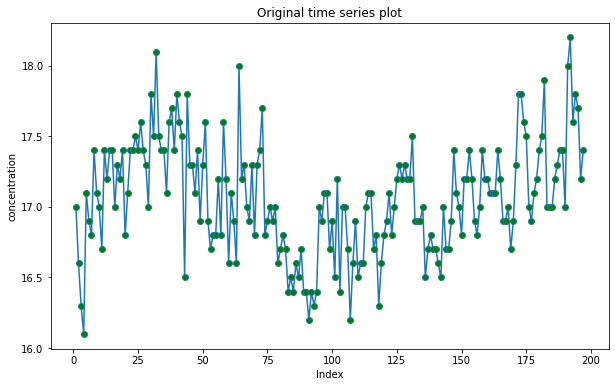

In [15]:
plt.figure(figsize=(10,6))
plt.plot(data1['period'],data1['constration'],marker='o',markerfacecolor='green')
plt.title("Original time series plot")
plt.xlabel("Index")
plt.ylabel("concentration")
# 정상성은 만족하는 것으로 보인다.
#차분은 진행 x
#주기성은 없어보인다.
plt.savefig("./data1_origin_plot.png")

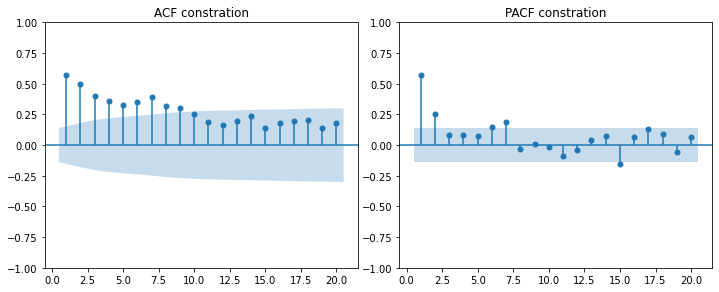

In [27]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(data1['constration'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF constration")


sgt.plot_pacf(data1['constration'], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF constration")
#ACF 가 천천히 감소한다. -> 차분을 수행한다.

#PACF : zero after lag 2

plt.savefig("./data1_origin_ACF_PACF.png")

In [29]:
data1_diff=data1['constration'].diff() # 판다스의 diff 메소드를 이용해 차분하는 방법

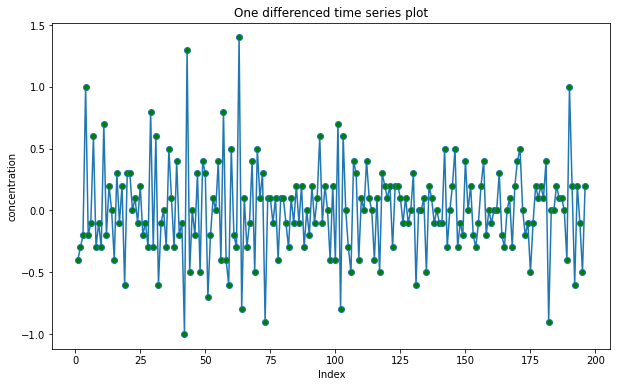

In [33]:
plt.figure(figsize=(10,6))
plt.plot(data1_diff,marker='o',markerfacecolor='green')
plt.title("One differenced time series plot")
plt.xlabel("Index")
plt.ylabel("concentration")
# 정상성은 만족하는 것으로 보인다.
#차분은 진행 x
#주기성은 없어보인다.
plt.savefig("./data1_diff_plot.png")

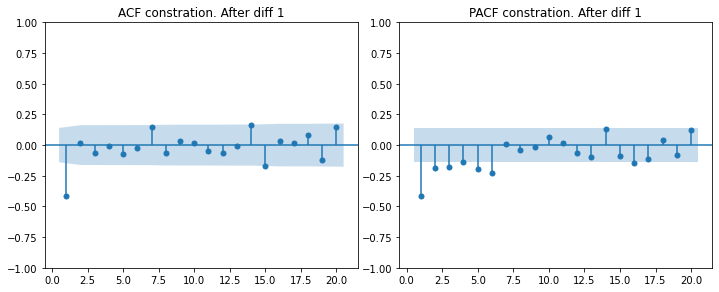

In [35]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(data1_diff.dropna(), lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF constration. After diff 1")


sgt.plot_pacf(data1_diff.dropna(), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF constration. After diff 1")

plt.savefig("./data1_diff_ACF_PACF.png")

# ACF : cut off after lag 1

# PACF : sinusoidal decay (찾아보기)


# IMA(1,1) 모형으로 추정된다.


# 하지만 주기 7씩 상승하는 주기가 발견된다. -> 잔차분석 필요.

In [37]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

model = ARIMA(data1['constration'], order=(0,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            constration   No. Observations:                  197
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -53.509
Date:                Sun, 27 Nov 2022   AIC                            111.017
Time:                        15:41:28   BIC                            117.574
Sample:                             0   HQIC                           113.672
                                - 197                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6994      0.058    -12.145      0.000      -0.812      -0.587
sigma2         0.1007      0.009     10.943      0.000       0.083       0.119
===================================================================================
Ljung-Box (L1) (Q):                   1.92   Jarque-Bera (JB):                 4.80
Prob(Q):                              0.17   Prob(JB):                         0.09
Heteroskedasticity (H):               0.69   Skew:                             0.25
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

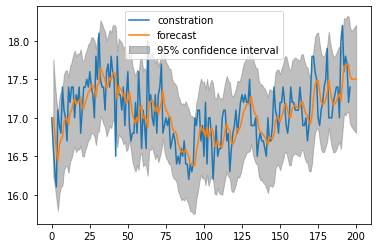

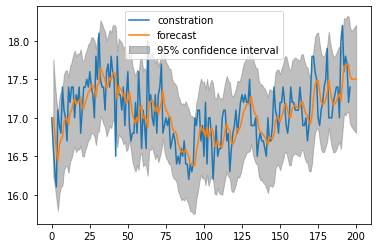

In [38]:
fig, ax = plt.subplots()
ax = data1['constration'].plot(ax=ax)
plot_predict(model_fit,1,200,ax=ax)

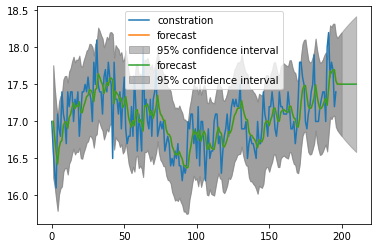

In [39]:
plot_predict(model_fit,1,210,ax=ax)

In [40]:
res=plot_predict(model_fit,1,200,ax=ax)

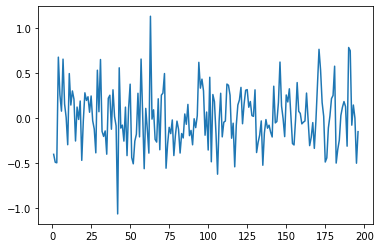

count    196.000000
mean       0.010963
std        0.318950
min       -1.060080
25%       -0.202122
50%       -0.011776
75%        0.215730
max        1.129610
dtype: float64


In [41]:
residuals=model_fit.resid[1:]
residuals.plot()
plt.show()
print(residuals.describe())

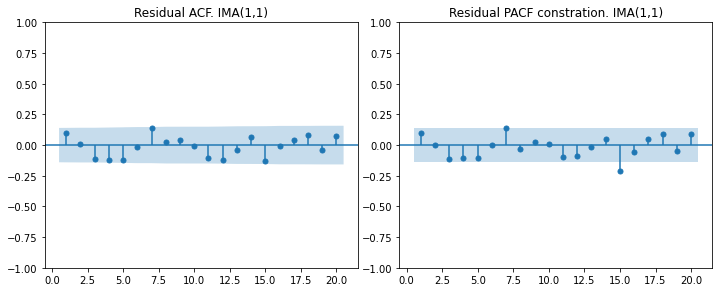

In [44]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(residuals.dropna(), lags = 20, zero = False, ax=ax1)
ax1.set_title("Residual ACF. IMA(1,1)")


sgt.plot_pacf(residuals.dropna(), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("Residual PACF constration. IMA(1,1)")

plt.savefig("./data1_IMA_RESID_ACF_PACF.png")




#12에서 acf와 pacf가 상승한것을 볼 수 있다.
#따라서, s=12 seasonal order (0,1,1) 모델을 적합한다.


In [44]:
np.mean(np.square(residuals))

0.10133025406040228

In [45]:

sm.stats.acorr_ljungbox(residuals, lags=[12,24,36,48], boxpierce=True,return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,20.667158,0.055472,19.782264,0.071319
24,32.394650,0.117504,30.333221,0.173952
36,55.956499,0.018082,49.926461,0.061316
48,60.650527,0.103977,53.646665,0.266769


residual은 0에 가깝고 std 0.3으로 관측된다. 

잔차가 랜덤으로 생각된다.

잔차에서 계절특징은 관찰되지 않는다.



7의 주기가 존재한다고 가정

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

model = ARIMA(data1['constration'], order=(0,1,1),seasonal_order=(0,0,1,7))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                     constration   No. Observations:                  197
Model:             ARIMA(0, 1, 1)x(0, 0, 1, 7)   Log Likelihood                 -51.299
Date:                         Sun, 27 Nov 2022   AIC                            108.598
Time:                                 16:15:34   BIC                            118.433
Sample:                                      0   HQIC                           112.580
                                         - 197                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6979      0.057    -12.290      0.000      -0.809      -0.587
ma.S.L7        0.1455      0.084      1.722      0.085      -0.020       0.311
sigma2         0.0984      0.009     11.208      0.000       0.081       0.116
===================================================================================
Ljung-Box (L1) (Q):                   1.71   Jarque-Bera (JB):                 7.61
Prob(Q):                              0.19   Prob(JB):                         0.02
Heteroskedasticity (H):               0.72   Skew:                             0.32
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

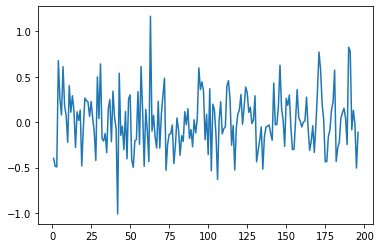

count    196.000000
mean       0.009832
std        0.315500
min       -1.011169
25%       -0.202941
50%       -0.007856
75%        0.199314
max        1.165901
dtype: float64


In [46]:
residuals=model_fit.resid[1:]
residuals.plot()
plt.show()
print(residuals.describe())

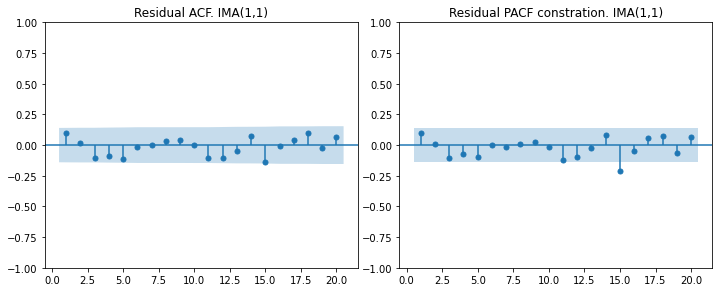

In [48]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(residuals.dropna(), lags = 20, zero = False, ax=ax1)
ax1.set_title("Residual ACF. IMA(1,1)")


sgt.plot_pacf(residuals.dropna(), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("Residual PACF constration. IMA(1,1)")

plt.savefig("./data1_SIMA_RESID_ACF_PACF.png")




#12에서 acf와 pacf가 상승한것을 볼 수 있다.
#따라서, s=12 seasonal order (0,1,1) 모델을 적합한다.


In [51]:
np.mean(np.square(residuals))

0.099128925208623

 sigma^2 은 약간 감소

In [52]:

sm.stats.acorr_ljungbox(residuals, lags=[12,24,36,48], boxpierce=True,return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,13.548646,0.330454,12.971780,0.371095
24,26.404941,0.332943,24.562825,0.429819
36,45.224893,0.139353,40.196729,0.289613
48,48.636280,0.447220,42.906650,0.681082


In [36]:
# arima(2,1,1)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

model = ARIMA(data1['constration'], order=(2,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            constration   No. Observations:                  197
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -50.799
Date:                Sun, 27 Nov 2022   AIC                            109.597
Time:                        15:32:17   BIC                            122.709
Sample:                             0   HQIC                           114.906
                                - 197                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2469      0.093      2.657      0.008       0.065       0.429
ar.L2          0.0946      0.102      0.928      0.353      -0.105       0.294
ma.L1         -0.8639      0.065    -13.209      0.000      -0.992      -0.736
sigma2         0.0979      0.009     10.537      0.000       0.080       0.116
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.36
Prob(Q):                              0.99   Prob(JB):                         0.07
Heteroskedasticity (H):               0.59   Skew:                             0.27
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 데이터 2

Monthly series of unemployed females between ages 16 and 19 in US from 
January 1961 to October 2002. (n = 500)

In [55]:
data2=pd.read_excel('./data/data2.xlsx')
data2.shape

(500, 3)

In [56]:
data2

,Year2,Mon2,UW
0,1961,1,347
1,1961,2,348
2,1961,3,365
3,1961,4,300
4,1961,5,311
...,...,...,...
495,2002,4,591
496,2002,5,570
497,2002,6,594
498,2002,7,587


In [57]:
data2['year-mon']=data2['Year2'].apply(str)+'-'+data2['Mon2'].apply(str)

In [58]:
data2['year-mon']=pd.to_datetime(data2['year-mon'], infer_datetime_format=True)

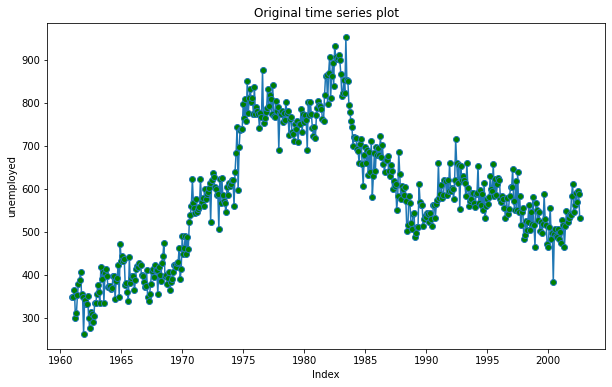

In [62]:
plt.figure(figsize=(10,6))
plt.plot(data2['year-mon'],data2['UW'],marker='o',markerfacecolor='green')
plt.title("Original time series plot")
plt.xlabel("Index")a
plt.ylabel("unemployed")
plt.savefig("./data2_origin_plot.png")


# 시간에 따라 평균이 달라지기에, 정상성을 만족하지 못한다.

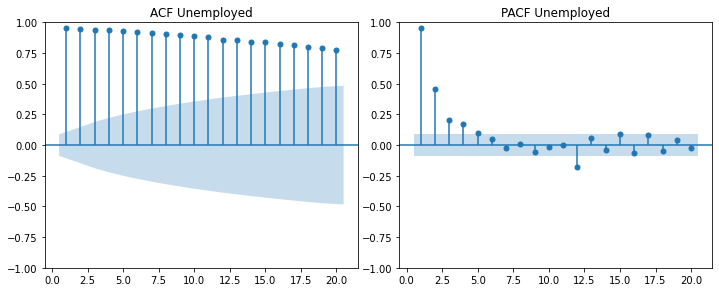

In [71]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(data2['UW'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF Unemployed")


sgt.plot_pacf(data2['UW'], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF Unemployed")

plt.savefig("./data2_origin_acf_pacf.png")


#ACF 가 천천히 감소한다. -> 차분을 수행한다.

#PACF : zero after lag 2로 추정된다.


PACF 가 sinusoidal decay가 된다.

In [72]:
data2_diff=data2['UW'].diff() # 판다스의 diff 메소드를 이용해 차분하는 방법

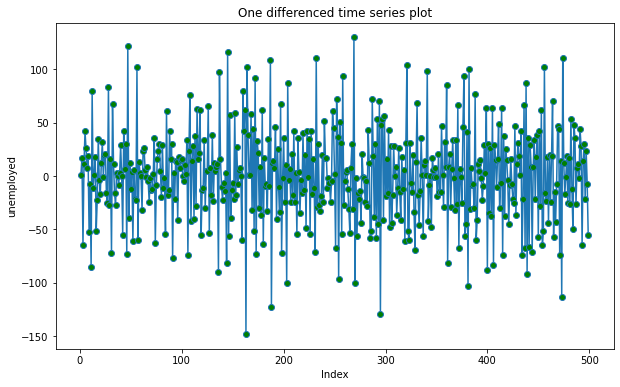

In [73]:
plt.figure(figsize=(10,6))
plt.plot(data2_diff,marker='o',markerfacecolor='green')
plt.title("One differenced time series plot")
plt.xlabel("Index")
plt.ylabel("unemployed")
plt.savefig("./data2_diff_plot.png")

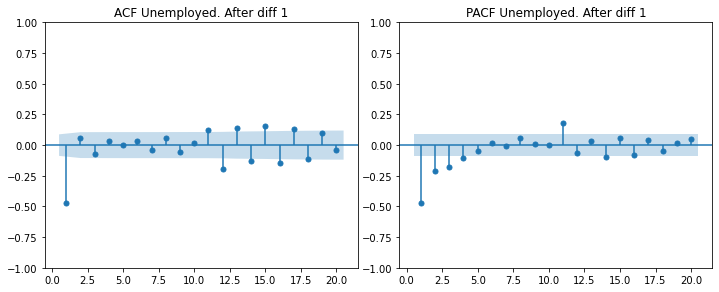

In [74]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(data2_diff.dropna(), lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF Unemployed. After diff 1")


sgt.plot_pacf(data2_diff.dropna(), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF Unemployed. After diff 1")

plt.savefig("./data2_diff_acf_pacf_plot.png")


#ACF : cut off after lag 1. 음수에서 시작

#PACF : cu sinusoidal decay (찾아보기)


# IMA(1,1) 모형으로 추정된다.
# 먼저 INA(1,1) 모형으로 추정

#####


# 또는 lag4 부터 sinusoidal decay로 보인다.-> 

#acf: oscilatory decay. 음수에서 시작 
# 1~4 : 지수적 감소 , 5~ : oscilatory

#하지만, acf와 pacf가 12 에서 다시 상승한것이 관찰된다.




In [80]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

model = ARIMA(data2['UW'], order=(0,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     UW   No. Observations:                  500
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2501.918
Date:                Sun, 27 Nov 2022   AIC                           5007.837
Time:                        17:43:08   BIC                           5016.262
Sample:                             0   HQIC                          5011.143
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6007      0.033    -18.309      0.000      -0.665      -0.536
sigma2      1324.6617     74.848     17.698      0.000    1177.963    1471.360
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 6.00
Prob(Q):                              0.52   Prob(JB):                         0.05
Heteroskedasticity (H):               1.01   Skew:                             0.10
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<ipython-input-81-b58cf50ba014>:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  residuals[:100].plot()


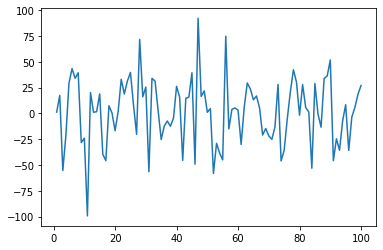

count    499.000000
mean       1.084681
std       36.420702
min     -118.856630
25%      -22.489744
50%        1.760893
75%       21.941997
max      114.351883
dtype: float64


In [81]:
residuals=model_fit.resid[1:]
residuals[:100].plot()
plt.show()
print(residuals.describe())


In [77]:

sm.stats.acorr_ljungbox(residuals, lags=[12,24,36,48], boxpierce=True,return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,22.814836,0.029340,22.288169,0.034414
24,54.876593,0.000325,52.994485,0.000579
36,68.207148,0.000943,65.457093,0.001920
48,84.967521,0.000800,80.713709,0.002173


잔차가 기각되어 , 잔차는 랜덤이 아님을 알 수 있다.

IMA(1,1) 모형 결과 잔차가 너무 크다.

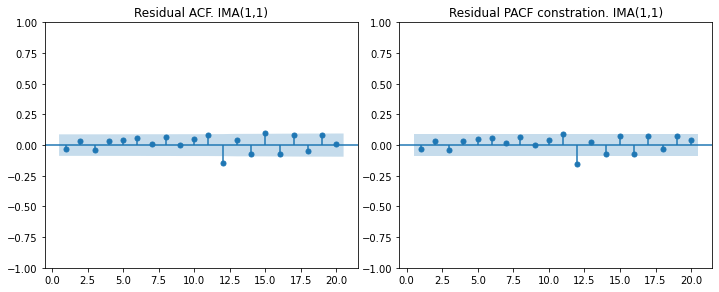

In [82]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(residuals.dropna(), lags = 20, zero = False, ax=ax1)
ax1.set_title("Residual ACF. IMA(1,1)")


sgt.plot_pacf(residuals.dropna(), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("Residual PACF constration. IMA(1,1)")

plt.savefig("./data2_ima_acf_pacf_plot.png")




#12에서 acf와 pacf가 상승한것을 볼 수 있다.
#따라서, s=12 seasonal order (0,1,1) 모델을 적합한다.


In [85]:
#(0,1,1) (0,0,1)12 모형 . seasonal ma 1 term.

model = ARIMA(data2['UW'], order=(0,1,1),seasonal_order=(0,0,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                               UW   No. Observations:                  500
Model:             ARIMA(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -2493.705
Date:                          Sun, 27 Nov 2022   AIC                           4993.411
Time:                                  17:55:22   BIC                           5006.048
Sample:                                       0   HQIC                          4998.370
                                          - 500                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5774      0.033    -17.427      0.000      -0.642      -0.512
ma.S.L12      -0.2315      0.049     -4.752      0.000      -0.327      -0.136
sigma2      1280.2005     71.248     17.968      0.000    1140.558    1419.843
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 7.31
Prob(Q):                              0.61   Prob(JB):                         0.03
Heteroskedasticity (H):               0.96   Skew:                             0.05
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

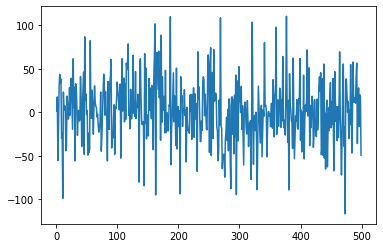

count    500.000000
mean       1.952433
std       38.988304
min     -117.005843
25%      -19.926502
50%        1.280782
75%       20.728675
max      347.000000
dtype: float64


In [86]:
residuals=model_fit.resid
residuals[1:].plot()
plt.show()
print(residuals.describe())

In [87]:

sm.stats.acorr_ljungbox(residuals, lags=[12,24,36,48], boxpierce=True,return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,13.637127,0.324478,13.398294,0.340768
24,35.637419,0.059492,34.481123,0.076474
36,49.249586,0.069530,47.200217,0.100207
48,64.231902,0.058648,60.816053,0.101392


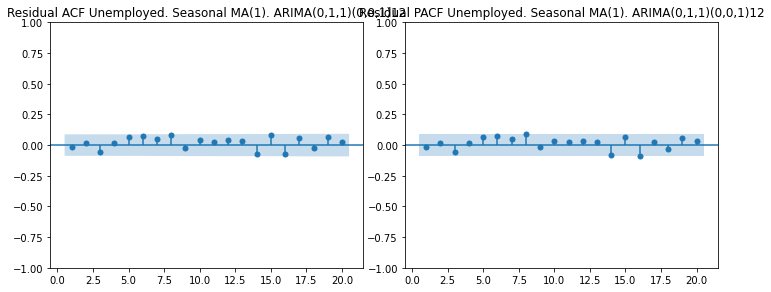

In [88]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.tight_layout()

sgt.plot_acf(residuals.dropna(), lags = 20, zero = False, ax=ax1)
ax1.set_title("Residual ACF Unemployed. Seasonal MA(1). ARIMA(0,1,1)(0,0,1)12")


sgt.plot_pacf(residuals.dropna(), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("Residual PACF Unemployed. Seasonal MA(1). ARIMA(0,1,1)(0,0,1)12")

plt.savefig("./data2_sarima_acf_pacf_plot.png")
